<a href="https://colab.research.google.com/github/NikoKaramitos/Vision/blob/main/DocScanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: DocScanner

## Goal:
make a python program that rectifies images from documents (like camcanner)

In [1]:
# Import Libraries
from skimage import transform
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
# Import all images
img_manual1 = cv2.imread("/content/IMG_8745.JPG")
img_manual2 = cv2.imread("/content/IMG_8746.JPG")
img_auto = cv2.imread("/content/bebi64i3kbb31.jpg")

# Switch color channels to RGB of all images
img_manual1 = cv2.cvtColor(img_manual1, cv2.COLOR_BGR2RGB)
img_manual2 = cv2.cvtColor(img_manual2, cv2.COLOR_BGR2RGB)
img_auto = cv2.cvtColor(img_auto, cv2.COLOR_BGR2RGB)

In [3]:
def computeH(im1_pts, im2_pts):
  assert im1_pts.shape == im2_pts.shape

  # Num of correspondence pairs
  n = im1_pts.shape[0]

  #init matrix A
  A = np.zeros((2*n, 8))

  # init matrix B
  b = np.zeros((2*n, 1))

  for i in range(n):
    x, y = im1_pts[i]
    x_prime, y_prime = im2_pts[i]

    # Fill values for pair
    A[2*i]     = [x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y]
    A[2*i + 1] = [0, 0, 0, x, y, 1, -y_prime*x, -y_prime*y]

    b[2*i]     = x_prime
    b[2*i + 1] = y_prime

  # Least Squares
  h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

  # Reshape recovered solution into 3x3 matrix
  # Construct H from h
  H = np.array([
      [h[0], h[1], h[2]],
      [h[3], h[4], h[5]],
      [h[6], h[7], 1]
  ])

  return H

In [4]:
def  warpImage(im,H,limit_coordinates):
  # your function goes here
  xmin, xmax, ymin, ymax = limit_coordinates

  # Define output shape
  output_shape = (ymax - ymin, xmax - xmin)

  # Warp image using given homography
  imwarped = transform.warp(im,
                            transform.ProjectiveTransform(matrix=H),
                            output_shape=output_shape,
                            clip=True,
                            mode='constant')

  imwarped = cv2.flip(imwarped,1)
  imwarped = cv2.rotate(imwarped, cv2.ROTATE_90_COUNTERCLOCKWISE)

  # convert back to 8bit
  if imwarped.dtype == np.float64:
    imwarped = (imwarped * 255).astype(np.uint8)

  return imwarped

## 1. Find the corners of the document to be rectified


In [5]:
def find_corners(image):

  # convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # threshold the image
  _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

  # find contours for edge detection
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # sort the contours
  cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]

  # approximate the shape of the polygon (rectangle) for corner detection
  epsilon = 0.02 * cv2.arcLength(cnt, True)
  approx = cv2.approxPolyDP(cnt, epsilon, True)

  if len(approx) == 4:
    return approx.reshape((4,2))
  else:
    return None

## 2. Find the transformation that maps points A, B, C, D to a new set of points in (0,0), (H,0), (H,W), and (0,W).

In [6]:
def rectify_document(image, manual=False):

  # Handle Manual Mode
  if manual:
    plt.imshow(image)
    plt.show()

    # Handle input from user for Corner points
    corners = []
    corner_names = ["Top Left", "Bottom Left", "Bottom Right", "Top Right"]
    for name in corner_names:
      coord_text = input(f"Input the cordinates for the corner {name} in 'x,y' format: ")
      x, y = map(int, coord_text.split(','))
      corners.append((x,y))
    corners = np.array(corners)

  # Handle Automated Mode
  else:
    corners = find_corners(image)
    plt.imshow(image)
    plt.scatter(corners[:, 0], corners[:, 1], c='red')
    plt.show()

  # 2. Define target points for warping based on detected bounding box
  width = max(int(np.linalg.norm(corners[2] - corners[1])), int(np.linalg.norm(corners[3] - corners[0])))
  height = max(int(np.linalg.norm(corners[1] - corners[0])), int(np.linalg.norm(corners[2] - corners[3])))


  target_pts = np.array([
      [0, 0],
      [height, 0],
      [height, width],
      [0, width]
  ])

  # compute homography matrix
  H = computeH(target_pts, corners)

  # 3. Perform warping operation
  limit_coordinates = [0, height, 0, width]
  warped = warpImage(image, H, limit_coordinates)
  warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

  return warped


In [7]:
# Resize image for viewing purposes based on orientation
def show_resized(image, max_size=500):

    h, w = image.shape[:2]
    if h > w:
        new_height = max_size
        new_width = int((max_size / h) * w)
    else:
        new_width = max_size
        new_height = int((max_size / w) * h)

    resized_img = cv2.resize(image, (new_width, new_height))
    cv2_imshow(resized_img)

## 3. Perform warping operation using the found transformation

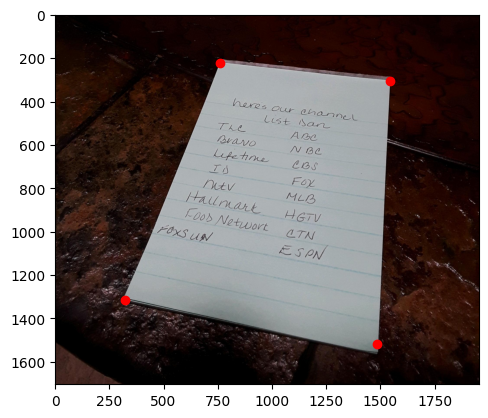

<ipython-input-3-b38ebf93c2c7>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  H = np.array([


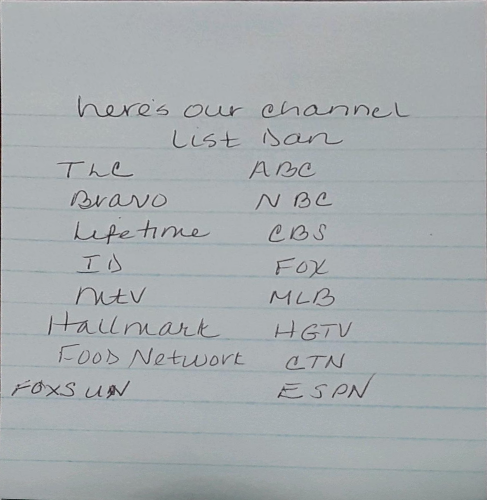

Points for Image 1: [1100,800], [1100,3800], [3000,3800], [3000,800]


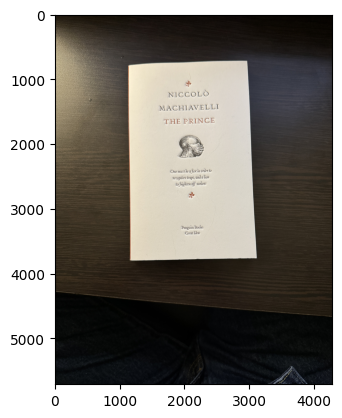

Input the cordinates for the corner Top Left in 'x,y' format: 1100,800
Input the cordinates for the corner Bottom Left in 'x,y' format: 1100,3800
Input the cordinates for the corner Bottom Right in 'x,y' format: 3000,3800
Input the cordinates for the corner Top Right in 'x,y' format: 3000,800


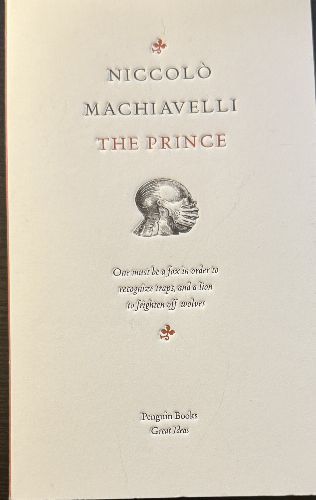

Points for Image 2: [600,350], [400,4600], [4000,4600], [3800,300]


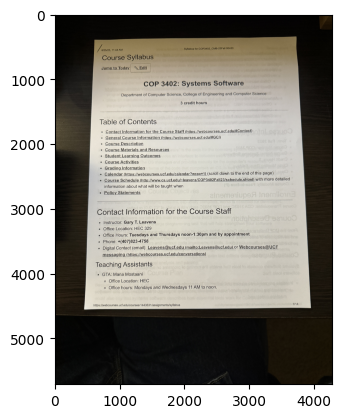

Input the cordinates for the corner Top Left in 'x,y' format: 600,350
Input the cordinates for the corner Bottom Left in 'x,y' format: 400,4600
Input the cordinates for the corner Bottom Right in 'x,y' format: 4000,4600
Input the cordinates for the corner Top Right in 'x,y' format: 3800,300


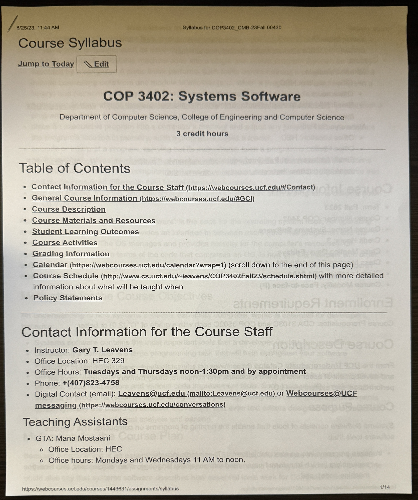

In [9]:
# Automated Mode Test
result1 = rectify_document(img_auto, False)
show_resized(result1)

# Manual Mode Test: 1
print("Points for Image 1: [1100,800], [1100,3800], [3000,3800], [3000,800]")
result2 = rectify_document(img_manual1, True)
show_resized(result2)

# Manual Mode Test: 2
print("Points for Image 2: [600,350], [400,4600], [4000,4600], [3800,300]")
result3 = rectify_document(img_manual2, True)
show_resized(result3)